In [1]:
import numpy as np 
import pandas as pd 

import sys
sys.path.append("/scratch/m/murray/dtolgay")

from get_spaxels import find_indices_inside_boxes

from tools import functions_readfiles as readfiles
from tools import constants
from tools import functions_importing_observations as observations

import h5py

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def read_gas_particles_from_hdf5(file_path: str) -> pd.DataFrame:
    
    with h5py.File(file_path, 'r') as f:
        part_group = f['PartType0']

        # Load vector quantities
        p = part_group['p'][:]   # shape (N, 3)
        v = part_group['v'][:]

        # Load scalar quantities
        m = part_group['m'][:]
        rho = part_group['rho'][:]
        h = part_group['h'][:]
        sfr = part_group['sfr'][:]
        u = part_group['u'][:]
        T = part_group['T'][:]
        hden = part_group['hden'][:]
        isrf = part_group['isrf_skirt'][:] 
        z = part_group['z'][:]          # shape (N, 11)

    # Build dataframe
    df = pd.DataFrame({
        'x': p[:, 0],
        'y': p[:, 1],
        'z': p[:, 2],
        'vx': v[:, 0],
        'vy': v[:, 1],
        'vz': v[:, 2],
        'mass': m,
        'density': rho,
        'smoothing_length': h,
        'star_formation_rate': sfr,
        'internal_energy': u,
        'temperature': T,
        'hden': hden,
        'isrf': isrf,
        'metallicity': z[:, 0],
        'He_mass_fraction': z[:, 1],
        'C_mass_fraction': z[:, 2],
        'N_mass_fraction': z[:, 3],
        'O_mass_fraction': z[:, 4],
        'Ne_mass_fraction': z[:, 5],
        'Mg_mass_fraction': z[:, 6],
        'Si_mass_fraction': z[:, 7],
        'S_mass_fraction': z[:, 8],
        'Ca_mass_fraction': z[:, 9],
        'Fe_mass_fraction': z[:, 10],
    })

    return df


def combine_chimes_hdf5_files(path_to_chimes_file: str, gas_particles_before_chimes: pd.DataFrame) -> pd.DataFrame:

    with h5py.File(path_to_chimes_file, 'r') as f:
        after_chimes = f['EqmChemistryAbundances'][:]  # Load the dataset into a NumPy array

    chimes = gas_particles_before_chimes.copy()

    nco_over_nh = after_chimes[:, 148]  # Get all rows of column 148
    nh2_over_nh = after_chimes[:, 137]  # Get all rows of column 137

    # Calculate the mass fraction of H2 and CO
    chimes['fCO'] = nco_over_nh * constants.mco_molecular_mass 
    chimes['fH2'] = nh2_over_nh * constants.mh2_molecular_mass

    # Determine the volume of each particle
    chimes['volume'] = chimes['mass'] / (chimes['density'] * constants.gr2M_sun) # cm3

    # Calculate the number density of H2 and CO
    chimes['density_h2'] = chimes['density'] / constants.mu_h  * chimes['fH2'] # gr/cm3
    chimes['density_co'] = chimes['density'] / constants.mu_h  * chimes['fCO'] # gr/cm3

    # Calculate the mass of H2 and CO 
    chimes['mass_h2'] = chimes['density_h2'] * chimes['volume'] # gr
    chimes['mass_co'] = chimes['density_co'] * chimes['volume'] # gr

    return chimes 

# Reading CLOUDY data

In [3]:
# Read the cloudy particles 

base_dir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius"

# galaxy_name = "gal0"
# galaxy_type = "firebox"

galaxy_name = "m12i_res7100_md"
galaxy_type = "zoom_in"

# directory_name = "voronoi_1e6"
# directory_name = "seperated_firebox_galaxies"
directory_name = "voronoi_1e5"

file_name = "abundance_RBFInterpolator_smoothingLength.txt"
redshift = "0.0"

fdir = f'{base_dir}/{galaxy_type}/z{redshift}/{galaxy_name}/{directory_name}/{file_name}'

cloudy, file_specific_columns = readfiles.read_interpolated_files_usingFilePath2(path = fdir, interpolation_type="abundance")

# Calculate mass densities
cloudy['density_h2'] = cloudy['density'] / constants.mu_h  * cloudy['fh2'] # gr/cm3
cloudy['density_co'] = cloudy['density'] / constants.mu_h  * cloudy['fCO'] # gr/cm3

# calcuulate the mass 
cloudy['volume'] = cloudy['mass'] / (cloudy['density'] * constants.gr2M_sun) # cm3
cloudy['mass_h2'] = cloudy['density_h2'] * cloudy['volume'] # gr
cloudy['mass_co'] = cloudy['density_co'] * cloudy['volume'] # gr


# Use only the cloudy particles within certain condition 
conditions = {
    "5kpc+disk":{
        "z_max": 500, # pc
        "Rgal": 5e3,  # pc
    }
}

cloudy["Rgal"] = np.sqrt(cloudy["x"]**2 + cloudy["y"]**2)
condition = (cloudy["Rgal"] < conditions["5kpc+disk"]["Rgal"]) & (abs(cloudy["z"]) < conditions["5kpc+disk"]["z_max"]) 
cloudy = cloudy[condition].copy().reset_index(drop=True)

# Reading CHIMES DATA

In [5]:
base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files"

# Read the hdf5 file 
hdf5_file_path = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}.hdf5"
print(f"Before chimes file path: {hdf5_file_path}")
before_chimes = read_gas_particles_from_hdf5(file_path = hdf5_file_path)

hdf5_files = {
    "B87x1" : {
        "file_path" : f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}_chimes_B87x1.hdf5",
        "data": pd.DataFrame(),
        "label": "B87x1",
    }, 
    "B87x01": {
        "file_path" : f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}_chimes_B87x0.1.hdf5",
        "data": pd.DataFrame(),
        "label": "B87x01",
    }, 
    # "B87x05": {
    #     "file_path" :f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}_chimes_B87x0.5.hdf5",
    #     "data": pd.DataFrame(),
    #     "label": "B87x05",
    # },
    "hx0.1": {
        "file_path" : f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}_chimes_hx0.10.hdf5",
        "data": pd.DataFrame(),
        "label": "hx0.1",
    }, 
    "hx0.01": {
        "file_path" : f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}_chimes_hx0.01.hdf5",
        "data": pd.DataFrame(),
        "label": "hx0.01",
    },
    # "starParticlesRF": {
    #     "file_path" : f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}_starParticlesRF_chimes.hdf5",
    #     "data": pd.DataFrame(),
    #     "label": "starParticlesRF",
    # },        
}

for key in hdf5_files.keys():
    path_to_chimes_file = hdf5_files[key]["file_path"]
    print(f"CHIMES file path: {path_to_chimes_file}")
    hdf5_files[key]["data"] = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

# path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x1.hdf5"
# chimes_B87x1 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

# path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x0.1.hdf5"
# chimes_B87x01 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

# path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x0.5.hdf5"
# chimes_B87x05 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

Before chimes file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/zoom_in/z0.0/m12i_res7100_md/m12i_res7100_md.hdf5
CHIMES file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/zoom_in/z0.0/m12i_res7100_md/m12i_res7100_md_chimes_B87x1.hdf5
CHIMES file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/zoom_in/z0.0/m12i_res7100_md/m12i_res7100_md_chimes_B87x0.1.hdf5
CHIMES file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/zoom_in/z0.0/m12i_res7100_md/m12i_res7100_md_chimes_hx0.10.hdf5
CHIMES file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/zoom_in/z0.0/m12i_res7100_md/m12i_res7100_md_chimes_hx0.01.hdf5


# Main

In [6]:
def calculate_spaxels(gas:pd.DataFrame, conditions:dict, resolution=1e3) -> pd.DataFrame:

    """
    resolution: pc
    """

    # Calculate the spaxel coordinates
    indices, lower_left_corner_coordinates, upper_right_corner_coordinates, box_coordinates = find_indices_inside_boxes(
        max_length = conditions["5kpc+disk"]["Rgal"], 
        resolution = resolution, 
        particles_df = gas, 
        overlap_shift=0
    )


    values_for_all_spaxels = []

    for indices_in_cell, lower_left_corner_coordinate in zip(indices, lower_left_corner_coordinates):
        
        # Initiate a dictionary to store the calculated values 
        calculated_properties = {} # Fresh start in each iteration.
        
        # Calculate the center coordinates of the spaxel
        x_center = lower_left_corner_coordinate[0] + resolution/2   # pc
        y_center = lower_left_corner_coordinate[1] + resolution/2   # pc     
        distance = np.sqrt(x_center**2 + y_center**2)               # pc 
        
        
        calculated_properties.update({
            "x_center": {
                "unit": "pc",
                "value": x_center,
                "column_name": "x_center",
            },
            "y_center": {
                "unit": "pc",
                "value": y_center,
                "column_name": "y_center",
            },
            "distance": {
                "unit": "pc",
                "value": distance,
                "column_name": "distance",
            },                        
        })    
        
        
        # Filter the particles 
        filtered_gas = gas.iloc[indices_in_cell].copy()
        
        # Calculate the total mass 
        total_co_mass = sum(filtered_gas["mass_co"])
        total_h2_mass = sum(filtered_gas["mass_h2"])
        
        # Calculate the surface number density 
        Nco = total_co_mass / (resolution * constants.pc2cm)**2 / constants.mco_gr # cm-2
        Nh2 = total_h2_mass / (resolution * constants.pc2cm)**2 / constants.mh2_gr # cm-2
        
        calculated_properties.update({
            "Nco": {
                "unit": "cm-2",
                "value": Nco,
                "column_name": "Nco",
            },
            "Nh2": {
                "unit": "cm-2",
                "value": Nh2,
                "column_name": "Nh2",
            },
        })
        
        
        # I calculated the spaxel properties. Now I will add it into the dataframe
        # Start a new arrays in after each spaxel.        
        values_for_this_run = []     
        column_names = [] 
        units = []   
        for key in list(calculated_properties.keys()):
            values_for_this_run.append(calculated_properties[key]["value"])
            column_names.append(f'{calculated_properties[key]["column_name"]}')
            units.append(f'{calculated_properties[key]["unit"]}')

        values_for_all_spaxels.append(values_for_this_run)



    ##### Outside of the loop 
    values_for_all_spaxels = np.array(values_for_all_spaxels)
    data_df = pd.DataFrame(values_for_all_spaxels, columns=column_names)        

    return data_df



In [7]:
resolution = 1e3
spaxels_cloudy = calculate_spaxels(gas=cloudy, conditions=conditions, resolution=resolution)

for key in hdf5_files.keys():
    chimes = hdf5_files[key]["data"]
    spaxels_chimes = calculate_spaxels(gas=chimes, conditions=conditions, resolution=resolution)
    hdf5_files[key]["spaxels"] = spaxels_chimes

# spaxels_chimes_B87x1 = calculate_spaxels(gas=chimes_B87x1, conditions=conditions, resolution=resolution)
# spaxels_chimes_B87x01 = calculate_spaxels(gas=chimes_B87x01, conditions=conditions, resolution=resolution)
# spaxels_chimes_B87x05 = calculate_spaxels(gas=chimes_B87x05, conditions=conditions, resolution=resolution)

1 finished. Left 99
Number of boxes: 100
Done!
1 finished. Left 99
Number of boxes: 100
Done!
1 finished. Left 99
Number of boxes: 100
Done!
1 finished. Left 99
Number of boxes: 100
Done!
1 finished. Left 99
Number of boxes: 100
Done!


In [8]:
# #################################### Plot
# R_max = 20e3 # pc

# print("Plotting galaxy")
# # Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# # First subplot: x-y axis plot
# axs[0].hist2d(
#     x=gas["x"],
#     y=gas["y"],
#     bins=500,
#     norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
# )
# axs[0].set_title('x-y axis plot')
# axs[0].set_xlabel('x')
# axs[0].set_ylabel('y')

# # Second subplot: z-y axis plot
# axs[1].hist2d(
#     x=gas["y"],  # Use the 'y' column for the x-axis
#     y=gas["z"],  # Keep the 'z' column for the y-axis
#     bins=500,
#     norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
# )
# axs[1].set_title('z-y axis plot')
# axs[1].set_xlabel('y')
# axs[1].set_ylabel('z')

# # Show the figure
# plt.tight_layout()

# Import observations

In [9]:
rachford = observations.rachford_2002_number_column_density(filedir = "/home/m/murray/dtolgay/Observations")
crenny = observations.crenny_2004_number_column_density(filedir = "/home/m/murray/dtolgay/Observations")
sheffer = observations.sheffer_2008_number_column_density(filedir = "/home/m/murray/dtolgay/Observations")
burgh = observations.burgh_2010_number_column_density(filedir = "/home/m/murray/dtolgay/Observations")

burgh.columns

Index(['StarName', 'Sp.Type', 'E(B − V )', 'A_V', 'Ref.', 'logN(Hi)', 'Ref._1',
       'logN(H2)', 'T_01', 'Ref._2', 'f^N', 'logN(CO)', 'logN(Hi)_error',
       'logN(H2)_error', 'logN(CO)_error'],
      dtype='object')

/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


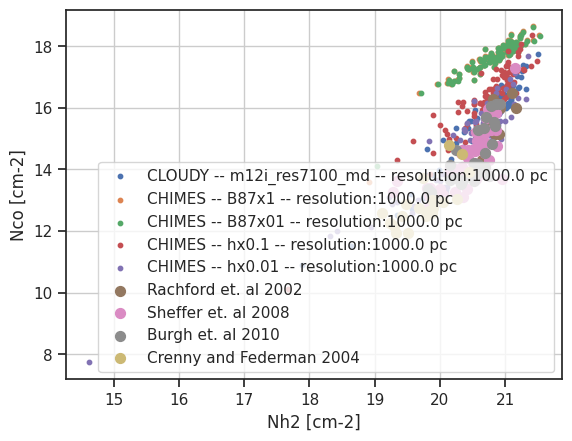

In [10]:
plt.scatter(
    np.log10(spaxels_cloudy["Nh2"]),
    np.log10(spaxels_cloudy["Nco"]),
    label = f"CLOUDY -- {galaxy_name} -- resolution:{resolution} pc",
    s = 10, 
)
for key in hdf5_files.keys():
    spaxels_chimes = hdf5_files[key]["spaxels"]
    label = hdf5_files[key]["label"]
    plt.scatter(
        np.log10(spaxels_chimes["Nh2"]),
        np.log10(spaxels_chimes["Nco"]),
        label = f"CHIMES -- {label} -- resolution:{resolution} pc",
        s = 10,
    )

plt.scatter(
    rachford["logN(H2)"],
    rachford["log(N(CO))"],
    label = "Rachford et. al 2002",
    s = 50, 
)

plt.scatter(
    sheffer['logH2'],
    sheffer['logCO'],
    label = "Sheffer et. al 2008",
    s = 50, 
)

plt.scatter(
    burgh['logN(H2)'],
    burgh['logN(CO)'],
    label = "Burgh et. al 2010",
    s = 50, 
)

plt.scatter(
    np.log10(crenny['Nh2']),
    np.log10(crenny['Nco']),
    label = "Crenny and Federman 2004",
    s = 50, 
)

plt.legend()
plt.grid(True)
plt.ylabel("Nco [cm-2]")
plt.xlabel("Nh2 [cm-2]")
plt.show()

In [19]:
def bin_data(spaxel_data):

    binned_data = []

    bins_Nh2 = np.linspace(start=5, stop=25, num=100)


    # Create mask for the data 
    for i in range(len(bins_Nh2)-1):
        mask = (np.log10(spaxel_data["Nh2"]) > bins_Nh2[i]) & (np.log10(spaxel_data["Nh2"]) < bins_Nh2[i+1])
        # Calculate the mean of Nco for the current bin
        mean_Nco = np.mean(spaxel_data["Nco"][mask])
        # Calculate the mean of Nh2 for the current bin
        mean_Nh2 = np.mean(spaxel_data["Nh2"][mask])

        # Calculate the standard deviation of Nco for the current bin
        std_Nco = np.std(spaxel_data["Nco"][mask])

        # Calculate the std on the log scale 
        log_std_Nco = np.std(np.log10(spaxel_data["Nco"][mask]))

        binned_data.append({
            "Nh2": mean_Nh2,
            "Nco": mean_Nco,
            "std_Nco": std_Nco,
            "log_std_Nco": log_std_Nco,
        })


    binned_data = pd.DataFrame(binned_data)

    return binned_data

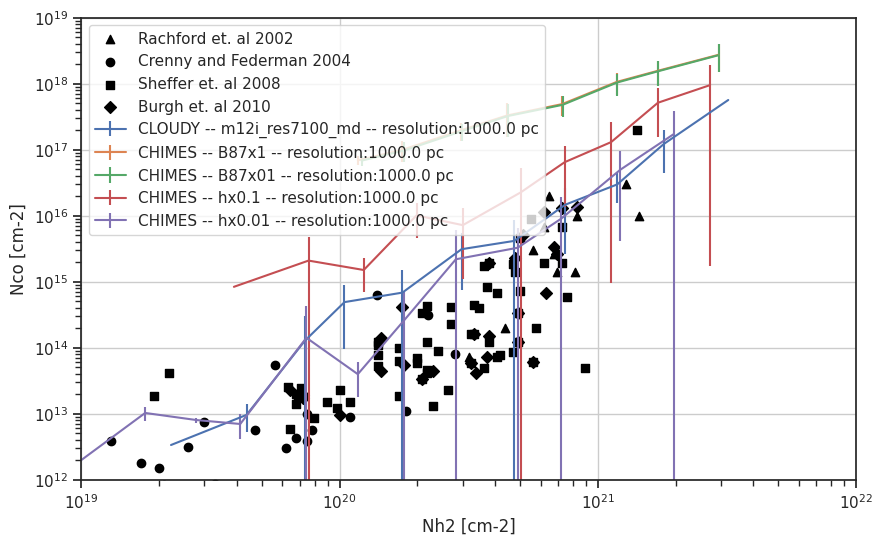

In [14]:
plt.figure(figsize=(10, 6))

binned_cloudy = bin_data(spaxel_data=spaxels_cloudy)
for key in hdf5_files.keys():
    spaxels_chimes = hdf5_files[key]["spaxels"]
    binned_chimes = bin_data(spaxel_data=spaxels_chimes)
    hdf5_files[key]["binned"] = binned_chimes

# Plot these binned data
plt.errorbar(
    binned_cloudy["Nh2"],
    binned_cloudy["Nco"],
    yerr=binned_cloudy["std_Nco"],
    label = f"CLOUDY -- {galaxy_name} -- resolution:{resolution} pc"
)

for key in hdf5_files.keys():
    binned_chimes = hdf5_files[key]["binned"]
    label = hdf5_files[key]["label"]
    plt.errorbar(
        binned_chimes["Nh2"],
        binned_chimes["Nco"],
        yerr=binned_chimes["std_Nco"],
        label = f"CHIMES -- {label} -- resolution:{resolution} pc"
    )

plt.scatter(
    10**rachford["logN(H2)"],
    10**rachford["log(N(CO))"],
    label = "Rachford et. al 2002",
    marker = '^',
    c = "black",
)

plt.scatter(
    crenny['Nh2'],
    crenny['Nco'],
    label = "Crenny and Federman 2004",
    marker = 'o',
    c = "black",    
)

plt.scatter(
    10**sheffer['logH2'],
    10**sheffer['logCO'],
    label = "Sheffer et. al 2008",
    marker = 's',
    c = "black",    
)

plt.scatter(
    10**burgh['logN(H2)'],
    10**burgh['logN(CO)'],
    label = "Burgh et. al 2010",
    marker = 'D',
    c = "black",    
)

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e19, 1e22])
plt.ylim([1e12, 1e19])
plt.grid(True)
plt.yticks([1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19])

plt.ylabel("Nco [cm-2]")
plt.xlabel("Nh2 [cm-2]")

plt.legend()

np.float64(0.0)

/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


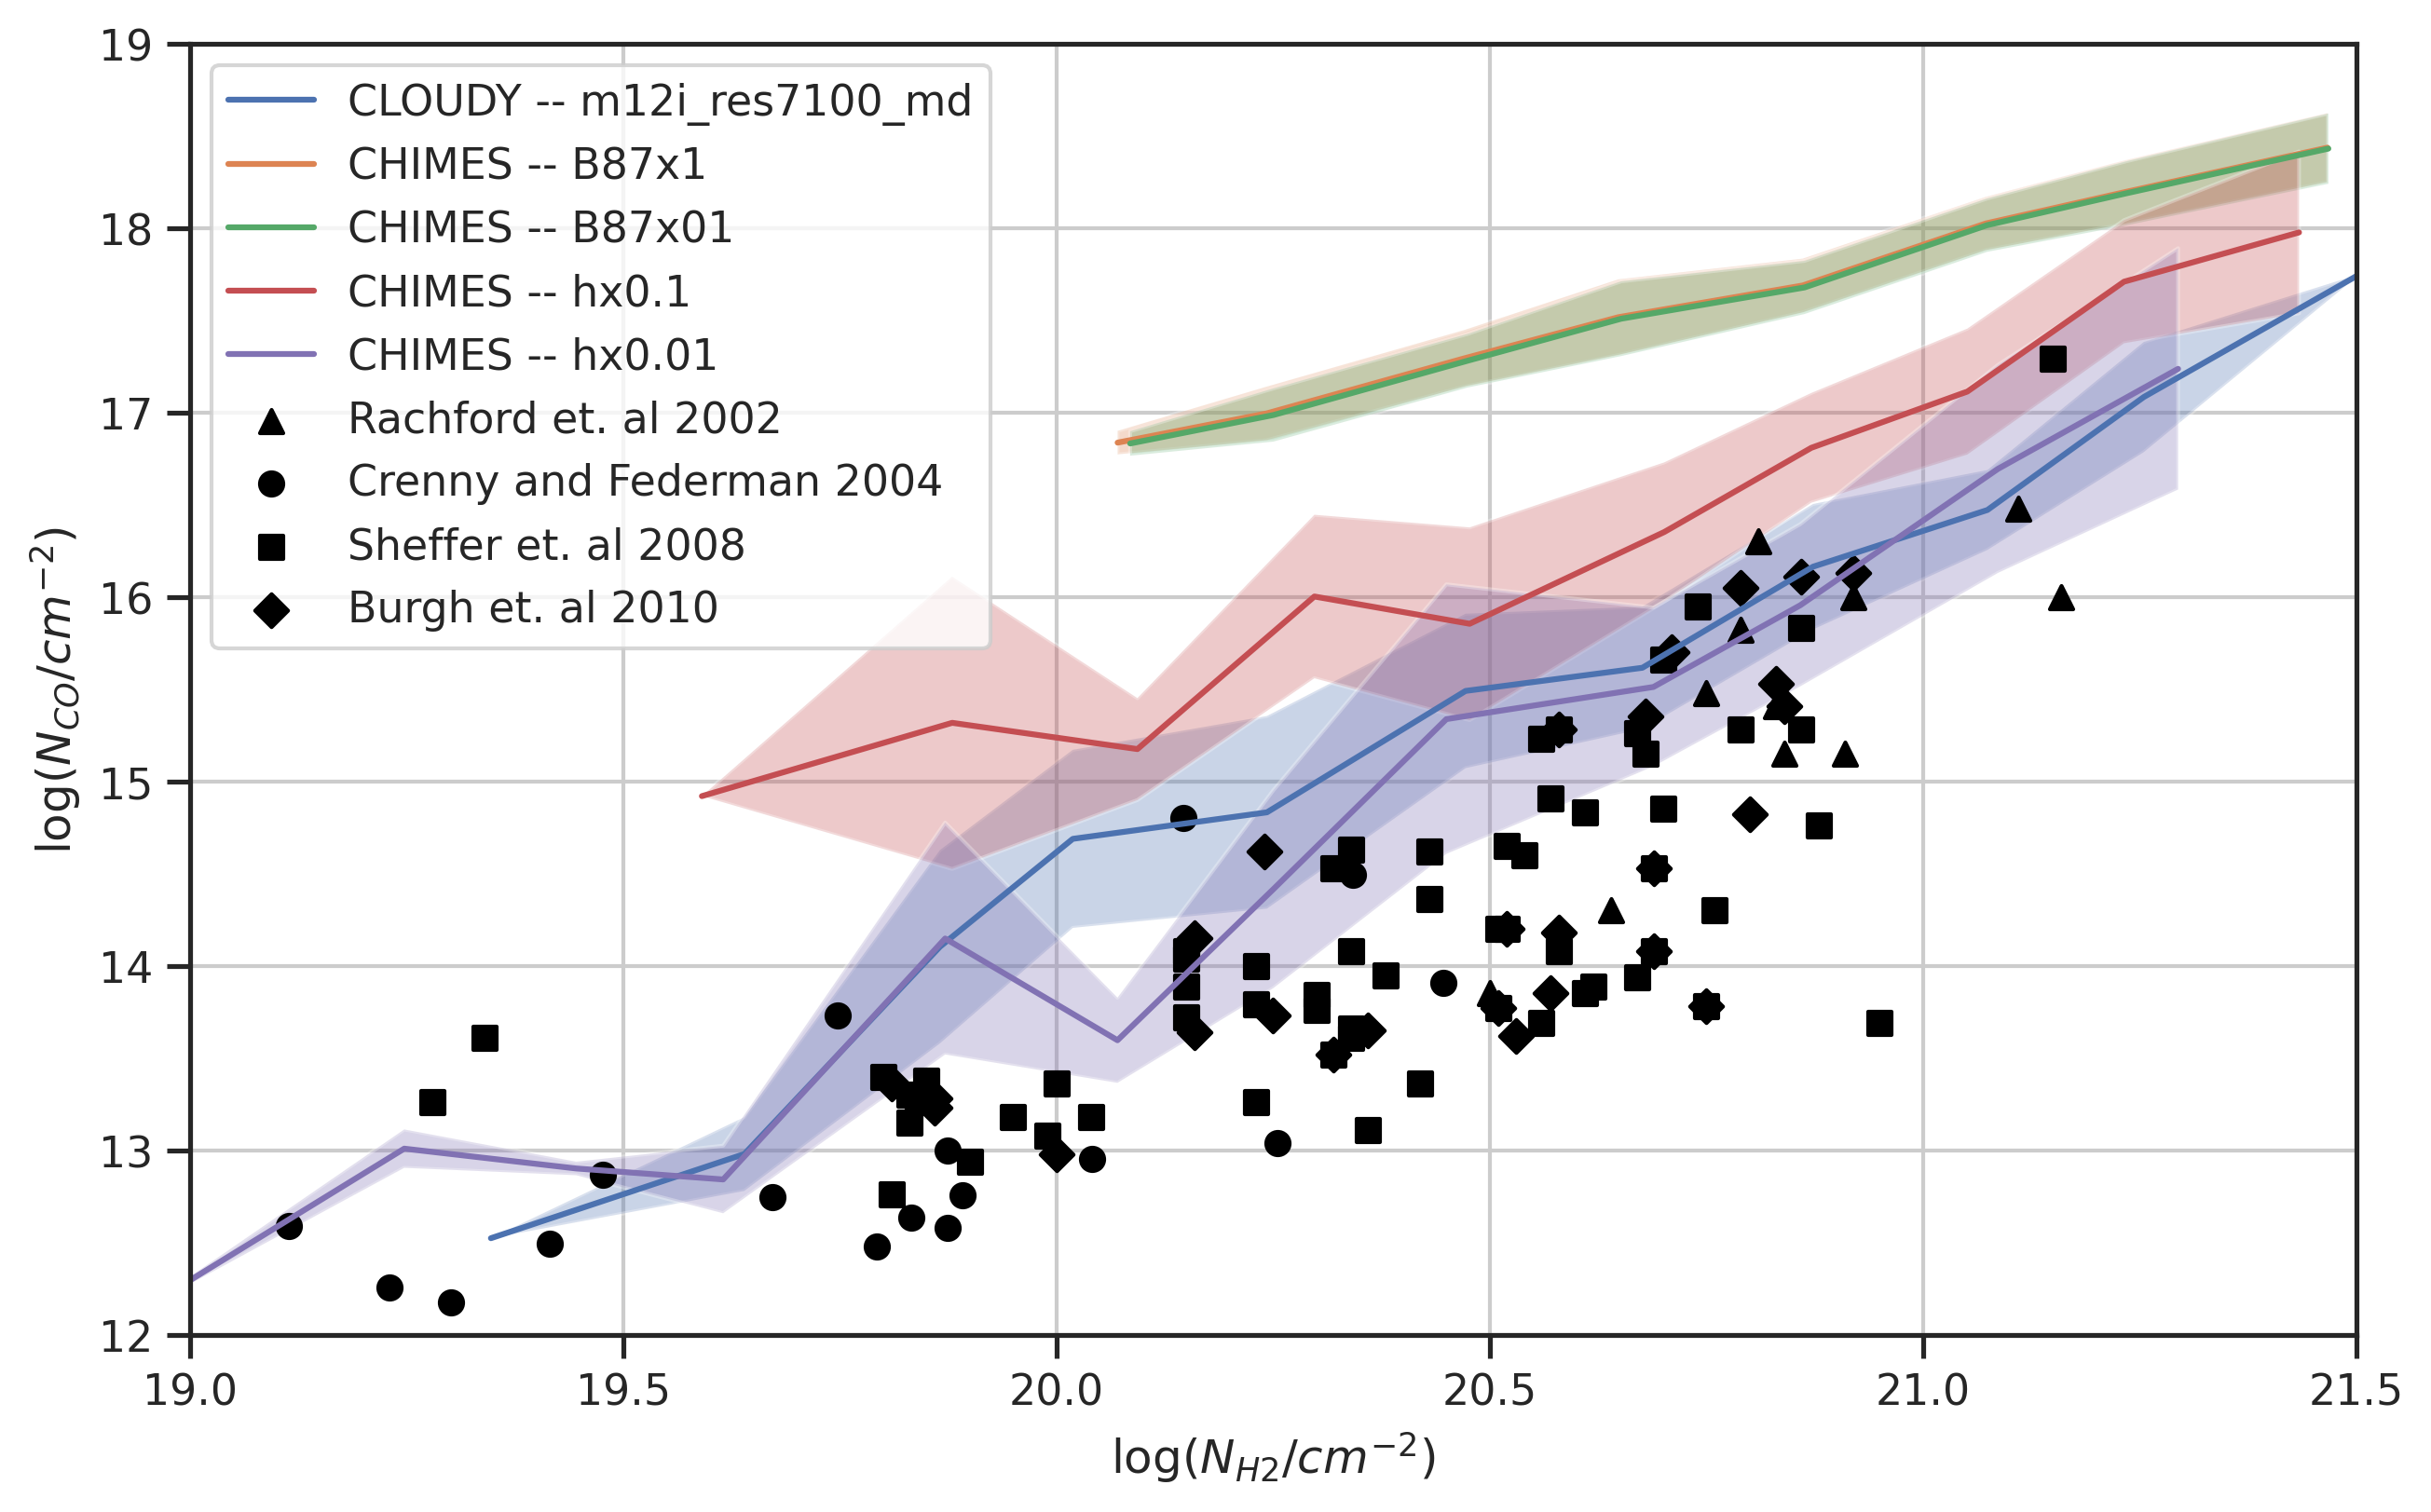

In [28]:
plt.figure(figsize=(10, 6), dpi=300, facecolor='white')

binned_cloudy = bin_data(spaxel_data=spaxels_cloudy)
for key in hdf5_files.keys():
    spaxels_chimes = hdf5_files[key]["spaxels"]
    binned_chimes = bin_data(spaxel_data=spaxels_chimes)
    hdf5_files[key]["binned"] = binned_chimes

# Plot CLOUDY data with fill_between
x = np.log10(binned_cloudy["Nh2"])
y = np.log10(binned_cloudy["Nco"])
yerr = binned_cloudy["log_std_Nco"]
plt.plot(x, y, label=f"CLOUDY -- {galaxy_name}")
plt.fill_between(x, y - yerr, y + yerr, alpha=0.3)

# Plot CHIMES data with fill_between
for key in hdf5_files.keys():
    binned_chimes = hdf5_files[key]["binned"]
    label = hdf5_files[key]["label"]
    x = np.log10(binned_chimes["Nh2"])
    y = np.log10(binned_chimes["Nco"])
    yerr = binned_chimes["log_std_Nco"]
    plt.plot(x, y, label=f"CHIMES -- {label}")
    plt.fill_between(x, y - yerr, y + yerr, alpha=0.3)


plt.scatter(
    rachford["logN(H2)"],
    rachford["log(N(CO))"],
    label = "Rachford et. al 2002",
    marker = '^',
    c = "black",
)

plt.scatter(
    np.log10(crenny['Nh2']),
    np.log10(crenny['Nco']),
    label = "Crenny and Federman 2004",
    marker = 'o',
    c = "black",    
)

plt.scatter(
    sheffer['logH2'],
    sheffer['logCO'],
    label = "Sheffer et. al 2008",
    marker = 's',
    c = "black",    
)

plt.scatter(
    burgh['logN(H2)'],
    burgh['logN(CO)'],
    label = "Burgh et. al 2010",
    marker = 'D',
    c = "black",    
)

plt.xlim([19, 21.5])
plt.ylim([12, 19])
plt.grid(True)
plt.yticks([12, 13, 14, 15, 16, 17, 18, 19])

plt.ylabel(r"log($N_{CO}$/$cm^{-2}$)")
plt.xlabel(r"log($N_{H2}$/$cm^{-2}$)")

plt.legend()

plt.savefig(
    f"{galaxy_name}_Nh2_Nco_comparison_res{resolution}pc.pdf",
    bbox_inches='tight'
)